# Deep Reinforcement Learning for Trading


##### <p style='text-align: right;'> by Yunze Zhu </p>


This project is using deep reinfocement learning (deep Q-learning) for High-frequency trading in futures market and stock market.

## Part 1. Import Libraries and Datasets

### Import libraries


The imports libraries includes numpy, pandas, tensorflow, sklearn, matplotlib, and other common used python build in libraries.

In [4]:
import numpy as np
import pandas as pd
import random
import os
import math
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Subtract
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from collections import deque
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

### Create the constant variables

There are 2 datasets from the previous data processing. All the data in the scaled dataset has been cleaned and nomaliezed between 0 to 1 for traning porpuses. The data in the reaw dataset contians the data that we are going to use in the enviorment to caluclate the current status of the agent in the market.

The save path is the location to save the models during training.

In [5]:
# constant variables
scaled_file_path = 'data/jd_scaled.csv'
raw_file_path = 'data/jd_raw.csv'
save_path = 'model/model_4/model_'

### Read in data

In [9]:
def read_to_df(file_path, raw = False):
    """
    read the csv file to a pandas data frame.
    
    Args:
        file_path: a string of the file's location
        raw: optional boolean valible, check if the data read in is raw
        
    Returns:
        A pandas dataframe of the given csv.
    """
    
    df = pd.read_csv(file_path)
    if not raw:
        df = df.drop(['Unnamed: 0'], axis=1)
    #dealing with null
    if df.isnull().sum().sum() != 0:
        df = df.replace(np.nan, 0)
    return df

Read in the datasets in the pandas dataframes 

In [10]:
df_scaled = read_to_df(scaled_file_path)
df_raw = read_to_df(raw_file_path, raw=True)

In [11]:
# check if null in the data set.
df_scaled.isnull().sum()
df_raw.isnull().sum().sum()

0

The scaled dataset

In [12]:
df_scaled

,buy_scaled_50,buy_scaled_200,buy_scaled_500,sell_scaled_50,sell_scaled_200,sell_scaled_500,buy_MA500,buy_MA500_win,buy_MA2500
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.948718,0.948718,0.948718,0.818182,0.818182,0.818182,0.948718,0.948718,0.948718
4,0.897436,0.897436,0.897436,0.818182,0.818182,0.818182,0.897436,0.897436,0.897436
...,...,...,...,...,...,...,...,...,...
1038085,1.000000,1.000000,0.545455,1.000000,1.000000,0.545455,0.554164,0.654545,0.398713
1038086,1.000000,1.000000,0.545455,1.000000,1.000000,0.545455,0.553439,0.654545,0.399077
1038087,1.000000,1.000000,0.545455,1.000000,1.000000,0.545455,0.552713,0.654545,0.399477
1038088,1.000000,1.000000,0.545455,1.000000,1.000000,0.545455,0.552168,0.654545,0.399876


The raw dataset

- Not all the data in this dataset is going to be used in the following part

In [13]:
df_raw

,Unnamed: 0,last_price,highest,lowest,bid_price1,bid_volume1,ask_price1,ask_volume1,volume,ask_price1_MA500,...,buy_scaled_500,sell_scaled_50,sell_scaled_200,sell_scaled_500,buy_MA500,buy_MA500_win,ask_price1_MA2500,buy_MA2500,selling_price_scaled,buying_price_scaled
0,0,3800.0,3800.0,3800.0,3797.0,2,3800.0,16,22,3800.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3800.000000,0.000000,0.343254,0.344214
1,1,3827.0,3830.0,3796.0,3803.0,5,3830.0,8,114,3815.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3815.000000,1.000000,0.349206,0.373887
2,2,3830.0,3839.0,3796.0,3830.0,6,3839.0,1,168,3823.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3823.000000,1.000000,0.375992,0.382789
3,3,3823.0,3839.0,3796.0,3824.0,1,3837.0,2,180,3826.500000,...,0.948718,0.818182,0.818182,0.818182,0.948718,0.948718,3826.500000,0.948718,0.370040,0.380811
4,4,3827.0,3839.0,3796.0,3824.0,1,3835.0,2,197,3828.200000,...,0.897436,0.818182,0.818182,0.818182,0.897436,0.897436,3828.200000,0.897436,0.370040,0.378833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038085,1038085,3493.0,3502.0,3452.0,3492.0,15,3493.0,169,75536,3493.095808,...,0.545455,1.000000,1.000000,0.545455,0.554164,0.654545,3491.385846,0.398713,0.040675,0.040554
1038086,1038086,3493.0,3502.0,3452.0,3492.0,18,3493.0,167,75539,3493.087824,...,0.545455,1.000000,1.000000,0.545455,0.553439,0.654545,3491.389844,0.399077,0.040675,0.040554
1038087,1038087,3493.0,3502.0,3452.0,3492.0,20,3493.0,167,75539,3493.079840,...,0.545455,1.000000,1.000000,0.545455,0.552713,0.654545,3491.394242,0.399477,0.040675,0.040554
1038088,1038088,3493.0,3502.0,3452.0,3492.0,22,3493.0,157,75549,3493.073852,...,0.545455,1.000000,1.000000,0.545455,0.552168,0.654545,3491.398641,0.399876,0.040675,0.040554


···························································································································

## Part 2. Agent and Training

### Agent

In [14]:
class Agent:

    """
    This is the agent class that contains all the methods and attributes of the agent. 
    The agent could have 3 different types of the models depend on the situation.
    
    Attributes:
        state_size: an int indicating the number of state of the information form the envoriment
        action_size: an int indicating the number of actions that the
        train: a pandas dataframe contains the traning data. Have to be normalized.
        model_name: optional string variable has the path of the model that want to be loaded. 
        is_eval: optional boolean variable, if this is model is for evaluation.
        is_LSTM: optional boolean variable, if use the LSTM method for the model. 
    """

    def __init__(self, state_size, action_size, train, model_name='', is_eval=False, is_LSTM = False):
        self.state_size = state_size
        self.action_size = action_size      # buy, sell, sit
        self.memory = deque(maxlen=100)
        self.inventory_price = 0
        self.inventory_number = 0
        self.inventory_list = []
        self.is_eval = is_eval
        self.traini = train

        self.gamma = 0.95
        self.epsolon = 1.0
        self.epsolon_min = 0.01
        self.epsolon_decay = 0.9975
        
        if is_eval:
            self.model = load_model("model/" + model_name)
        elif is_LSTM:
            self.model = self._LSTM_model()
        else:
            self.model = self._model()

    # create the model
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(units=32, activation='relu'))
        
        model.add(Dense(units=8, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))        
        return model
    
    
    # create the LSTM model
    def _LSTM_model(self):
        # TODO:
        model = Sequential()
        model.add(LSTM(units=128, input_shape=(X_train.shape[1:])))
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=8, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.0001))        
        return model
    
    # create a dqn model
    def _dqn_model(self, state):
        
        # TODO:
        dropout_rate = 0.1
        inputs = Input(shape=(state.shape[1], state.shape[2], state.shape[3]))
        
        x = Conv2D(16, 
                   (4, state.shape[2]), 
                   input_shape = (state.shape[1], state.shape[2], 1), 
                   padding='valid', 
                   data_format='channels_last', 
                   activation = 'relu')(inputs)
        y1 = Conv2D(16, 
                   (4, state.shape[1]), 
                   input_shape = (state.shape[1], state.shape[2], 1), 
                   padding='valid', 
                   data_format='channels_last', 
                   activation = 'relu')(inputs)
        y2 = Conv2D(16, 
                   (1, 1), 
                   padding='valid', 
                   activation = 'relu')(y1)
        y3 = Conv2D(16, 
                   (1, 1), 
                   padding='valid', 
                   activation = 'relu')(y2)
        y = Conv2D(16, (1, 1), padding='valid', activation = 'relu')(y3)
        
        out = Multiply()([x,y])
        
        z1 = Reshape((state.shape[1]-1,16), input_shape=(state.shape[1]-1,16))(out)
        z2 = Conv1D(8, 3, input_shape=(state.shape[1]-1,16), activation = 'relu')(z1)
        z3 = Conv1D(4, 2, activation = 'relu')(z2)
        z4 = Dropout(dropout_rate)(z3)
        z5 = Flatten()(z4)
        z6 = Dense(3, activation='linear')(z5)
        model = Model(inputs=inputs, outputs=z6)
        
        model.compile(loss='mae', optimizer = 'nadam')
        return model
        

    def act(self, state):
        """
        action of the agent
        
        Args:
            state: a list of float indicating the current state, whith the length of state_size
        
        Returns:
            a integer from the action space. 
        """
        
        options = self.model.predict(state)
        
        if not self.is_eval and np.random.rand()<= self.epsolon:
            return random.randrange(self.action_size), options
    
        if np.isnan(np.sum(options)):
            print('!!!!! NaN !!!!!')

        return np.argmax(options[0]), options
    
    
    
    def expReplay(self, batch_size):

        mini_batch = []
        l = len(self.memory)
        for i in range(1-batch_size+1,1):
            mini_batch.append(self.memory[i])

        for state, action, reward, next_state, done in mini_batch:
            target_f = self.model.predict(state)
            target_f[0][action] = reward[action]
            temP = reward[action] + self.gamma * np.argmax(self.model.predict(next_state)[0])
            target_f[0][action] = temP
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsolon> self.epsolon_min:
            self.epsolon *= self.epsolon_decay
            
        self.memory = deque(maxlen=100)
    
    def expReplay2(self, batch_size, is_print_predict = False):
        """
        replay the past states and update the model
        
        Args:
            batch_size: a int of the size of each batch
            is_print_predict: option variable for debug. 
        
        """
        mini_batch = []
        l = len(self.memory)
        for i in range(1-batch_size+1,1):
            mini_batch.append(self.memory[i])

        for state, action, reward, next_state, done, prdct in mini_batch:
#             prdct = self.model.predict(state)
            target = reward
#             target = reward+self.gamma*np.argmax(self.model.predict(next_state)[0])
            target = reward+self.gamma*np.amax(self.model.predict(next_state)[0])
            target_f = prdct
            if is_print_predict:
                print(np.argmax(target_f), action, target_f, target)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        
            
        if self.epsolon> self.epsolon_min:
            
            self.epsolon *= self.epsolon_decay
            
        self.memory = deque(maxlen=100)

### Train

In [16]:
def train(agent, epochs, data_array, data, start_point, end_point, reward_low_bound = 0, sit_reward = 0,
          batch_size = 32, save_path = 'model/default/model_', 
          save_num = 5000, reward_buy = False, is_print_predict = False, 
          negtive_reward = False):
    
    """
    function for traning
    
    Args:
        agent: Agent obejct is the current agent running the trading
        epochs: int. number of epochs of the training.
        data_array: np array. scaled data in the np array format
        data: pandas df. raw data for the enviorment
        start_point: int. start point of the trading
        end_point: int end point of the trading
        reward_low_bound: optional variable for reward setting.
        sit_reward: optional variable for reward sit action.
        batch_size: optional variable for batch size
        save_path: optional variable for path of saving the model
        save_num: optional variable for saving the model after how many data points
        reward_buy: optional variable for if rewarding the buy action
        is_print_roedict: optional variable for debug
        negtive_reward: optional variable for if give the agent negaive rewards
    """
    
    t1 = time.time()
    l = len(data_array)

    for e in range(1, epochs):
        
        state = data_array[0:1]
        
        total_profit = 0
        money_in_stock = 0

       
        price = data['ask_price1'].values
        ask_vol = data['ask_volume1'].values

        bid_price = data['bid_price1'].values
        bid_vol = data['bid_volume1'].values

        agent.inventory_price = 0
        agent.inventory_number = 0
        agent.inventory_list = []

        action_buffer = 1 #to store the previous action. Start at 1 = sell
        price_buffer = price[0]

        min_buy_price = deque(maxlen = 10)

        
        for t in range(start_point, end_point+1):

            if t%100 == 0:
                t2 = time.time()
                print('Day:', str(t), 'time:', str(t2-t1))
                t1 = t2

            action, prdct= agent.act(state)
            next_state = data_array[t:t+1]

            reward = 0

            #2 buy, 1 sell, 0 sit
            #BUY
            if action == 2 :

                buy_in_num = min(ask_vol[t], 10) # compare the ask volume and 5, choose the smaller one
                
                if reward_buy:
                    if agent.inventory_number ==0 :
                        unit_price = 0
                    else:
                        unit_price = agent.inventory_price/agent.inventory_number

                    if len(min_buy_price) == 0:
                        min_buy_price.append(unit_price)

                    r= np.min(min_buy_price) - price[t] - 1 
                    if negtive_reward:
                        reward = r
                    else:
                        reward = max(r, reward_low_bound)
                    min_buy_price.append(price[t])

                agent.inventory_number += buy_in_num # 数
                agent.inventory_price += buy_in_num * price[t] # 总

                print (t, "|Buy: ", str(price[t]),
                       "|n:", str(buy_in_num),
                       "|i$:", str(agent.inventory_price), 
                       "|in:", str(agent.inventory_number))


            #SELL
            elif action ==1 :
                # market pricing and number
                bid_p = bid_price[t]
                bid_n_raw = bid_vol[t]
                # the number of selling
                
                #TODO:
#                 if agent.inventory_number>200:
#                     large = 0.9*agent.inventory_number
#                 else:
#                     large = 20

                bid_n = min(bid_n_raw, 10)
                sell_num = min(bid_n, agent.inventory_number)
                # unit price of current inventory
                if agent.inventory_number == 0:
                    unit_price = 0
                else:
                    unit_price = agent.inventory_price/agent.inventory_number
                # cost 
                cost = unit_price*sell_num
                # remove from inventory
                agent.inventory_number -= sell_num
                agent.inventory_price -= cost
                # set reward
                price_difference = bid_p - unit_price
                if agent.inventory_number == 0:
#                     action = 0
                    reward = 0 
                else:
                    if negtive_reward:
                        reward = price_difference 
                    else:
                        reward = max(price_difference, reward_low_bound)
                
                #profit
                profit = bid_p*sell_num - cost
                total_profit +=profit

                print (t, "|Sell:", str(bid_p), 
                       "|n:", str(sell_num),       
                       "|i$:", str(agent.inventory_price), 
                       "|in:", str(agent.inventory_number),
                       "|p:", str(profit),    
                       "|t:", str(total_profit))
            
            #sit
            else:
                if negtive_reward:
                    reward = 0
                else:
                    reward = sit_reward
                print (t, "|Sit:", str(price[t]))
                    
                
            
            if t==end_point:
                done = True
            else:
                done = False

            agent.memory.append((state, action, reward, next_state, done, prdct))


            state = next_state

            if done:
                print('---------------------------------------')
                print("Total Profit:", str(total_profit))
                print('---------------------------------------')

            if len(agent.memory)>batch_size:
                agent.expReplay2(batch_size, is_print_predict = is_print_predict)

            if t%save_num == 0 or done:
                print('### SAVING ###')
                agent.model.save(save_path+'ep'+str(e)+'_'+str(t))
    

#### ----------------------------------------------------------------------------------------------------------------

In [17]:
data_scaled = df_scaled.values
data_scaled.shape

(1038090, 9)

In [18]:
#check if NaN
np.isnan(np.sum(data_scaled))

False

create an agent object for traning

In [19]:
agent_train = Agent(9,3,data_scaled)

In [21]:
# agent_train.model = load_model('model/model_1/model_rb3')
# summary of the agent model
agent_train.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                960       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________


train(agent_train, 10, data_scaled, df_raw, 480001, 540001, reward_low_bound= -0.1, sit_reward=0,
       save_path= save_path, save_num=20000, reward_buy=True, is_print_predict=False, negtive_reward=False)

train(agent_train, 10, data_scaled, df_raw, 480001, 540001, reward_low_bound=0, sit_reward=0,
      save_path= 'model/model_5/model_', save_num=20000,reward_buy=True, is_print_predict=False, negtive_reward=False)

Start traning

In [ ]:
train(agent_train, 10, data_scaled, df_raw, 480001, 540001, reward_low_bound=0, sit_reward=0.01,
      save_path= 'model/model_5/model_', save_num=20000,reward_buy=True, is_print_predict=False, negtive_reward=False)

agent_train.model = load_model('model/model_5/model_ep0_500000')

## Step 3:

### Evaluation

In [24]:
def evaluation(agent, epochs, data_array, data, start_point, end_point, is_print_predict = False):
    
    """
    function for evaluation
    
    Args:
        agent: Agent obejct is the current agent running the trading
        epochs: int. number of epochs of the evaluation.
        data_array: np array. scaled data in the np array format
        data: pandas df. raw data for the enviorment
        start_point: int. start point of the trading
        end_point: int end point of the trading
        is_print_roedict: optional variable for debug
        
    Returns:
        buy_point: list of float indicates all the time point of taking the buying action
        \sell_point：list of float indicates all the time point of taking the selling action
        total_profit: an int, total number of profit made from the trading
        max_value: an int, the largest amount of money have been put into the market
        
    """
    
    t1 = time.time()
    l = len(data_array)
    
    buy_point = []
    sell_point = []
    
    max_value = 0

    for e in range(epochs):
        
        state = data_array[0:1]
        
        total_profit = 0
        money_in_stock = 0



        price = data['ask_price1'].values
        ask_vol = data['ask_volume1'].values

        bid_price = data['bid_price1'].values
        bid_vol = data['bid_volume1'].values

        agent.inventory_price = 0
        agent.inventory_number = 0
        agent.inventory_list = []

        action_buffer = 1 #to store the previous action. Start at 1 = sell
        price_buffer = price[0]

        min_buy_price = deque(maxlen = 10)
        
        buy_point = []
        sell_point = []
        
        timeseries_iter = 0

        
        for t in range(start_point, end_point+1):

            if t%100 == 0:
                t2 = time.time()
                print('Day:', str(t), 'time:', str(t2-t1))
                t1 = t2

            action, prdct= agent.act(state)
#             print(prdct)
            next_state = data_array[t:t+1]

            reward = 0
            

            #2 buy, 1 sell, 0 sit
            #BUY
            if action == 2 :

                buy_in_num = min(ask_vol[t], 10) # compare the ask volume and 5, choose the smaller one

                agent.inventory_number += buy_in_num # 数
                agent.inventory_price += buy_in_num * price[t] # 总
                
                buy_point.append((timeseries_iter, price[t]))

                print (t, "|Buy: ", str(price[t]),
                       "|n:", str(buy_in_num),
                       "|i$:", str(agent.inventory_price), 
                       "|i n:", str(agent.inventory_number))


            #SELL
            elif action ==1 :
                # market pricing and number
                bid_p = bid_price[t]
                bid_n_raw = bid_vol[t]
                # the number of selling

                bid_n = min(bid_n_raw, 10)
                sell_num = min(bid_n, agent.inventory_number)
                # unit price of current inventory
                if agent.inventory_number == 0:
                    unit_price = 0
                    flag_empty = True
                else:
                    flag_empty = False
                    unit_price = agent.inventory_price/agent.inventory_number
                # cost 
                cost = unit_price*sell_num
                # remove from inventory
                agent.inventory_number -= sell_num
                agent.inventory_price -= cost
                # set reward
                price_difference = bid_p - unit_price
                
                #profit
                profit = bid_p*sell_num - cost
                total_profit +=profit
                
                if flag_empty == False:
                    
                    sell_point.append((timeseries_iter, price[t]))
                
                    print (t, "|Sell:", str(bid_p), 
                       "|n:", str(sell_num),       
                       "|i$:", str(agent.inventory_price), 
                       "|i n:", str(agent.inventory_number),
                       "|p:", str(profit),    
                       "|t:", str(total_profit))
            
            #sit
            else:
                print (t, "|Sit:", str(price[t]))
            
            max_value = max(max_value, agent.inventory_price)
            
            timeseries_iter +=1 
                
            
            if t==end_point:
                done = True
            else:
                done = False

#             agent.memory.append((state, action, reward, next_state, done, prdct))

            state = next_state

            if done:
                print('---------------------------------------')
                print("Total Profit:", str(total_profit))
                print('---------------------------------------')
            
#         buy_point.append(buy_point_e)
#         sell_point.append(sell_point_e)
    
    return buy_point, sell_point, total_profit, max_value
            
                


Create an agent object for evaluation

In [25]:
agent_test = Agent(9,3,data_scaled, is_eval=True, model_name='model_5/model_ep0_520000')
agent_test.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                960       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 27        
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________


evaluation

In [ ]:
buy_point, sell_point, total_profit, max_value = evaluation(agent_test, 1, data_scaled, df_raw, 310001, 320001)

### Plot

In [67]:
def plot_action(df, buy_point, sell_point, model_name, start, end, if_save=True):
    data = df['ask_price1'].values[start:end]
    buy_data = np.array(buy_point)
    sell_data = np.array(sell_point)
    l = len(data)
    t = np.arange(0,l,1)

    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(t, data, label='jd', color = 'grey')
    ax.plot(buy_data[:, 0], buy_data[:, 1],'go', markersize = 1, label='Buy')
    ax.plot(sell_data[:, 0], sell_data[:, 1], 'ro', markersize = 1, label='Sell')

    legend = ax.legend(loc='upper right')
    plt.savefig('plot/'+str(model_name)+'_'+str(start)+'_'+str(end)+'.png', dpi=200)

In [ ]:
plot_action(df_raw, buy_point, sell_point, 'model_ep1_540001', 310001, 320001, if_save=True)

In [ ]:
total_profit

In [ ]:
max_value

In [ ]:
plot_action(df_raw, [], [], 'model_ep0_1000001', 800000, 1000000, if_save=False)

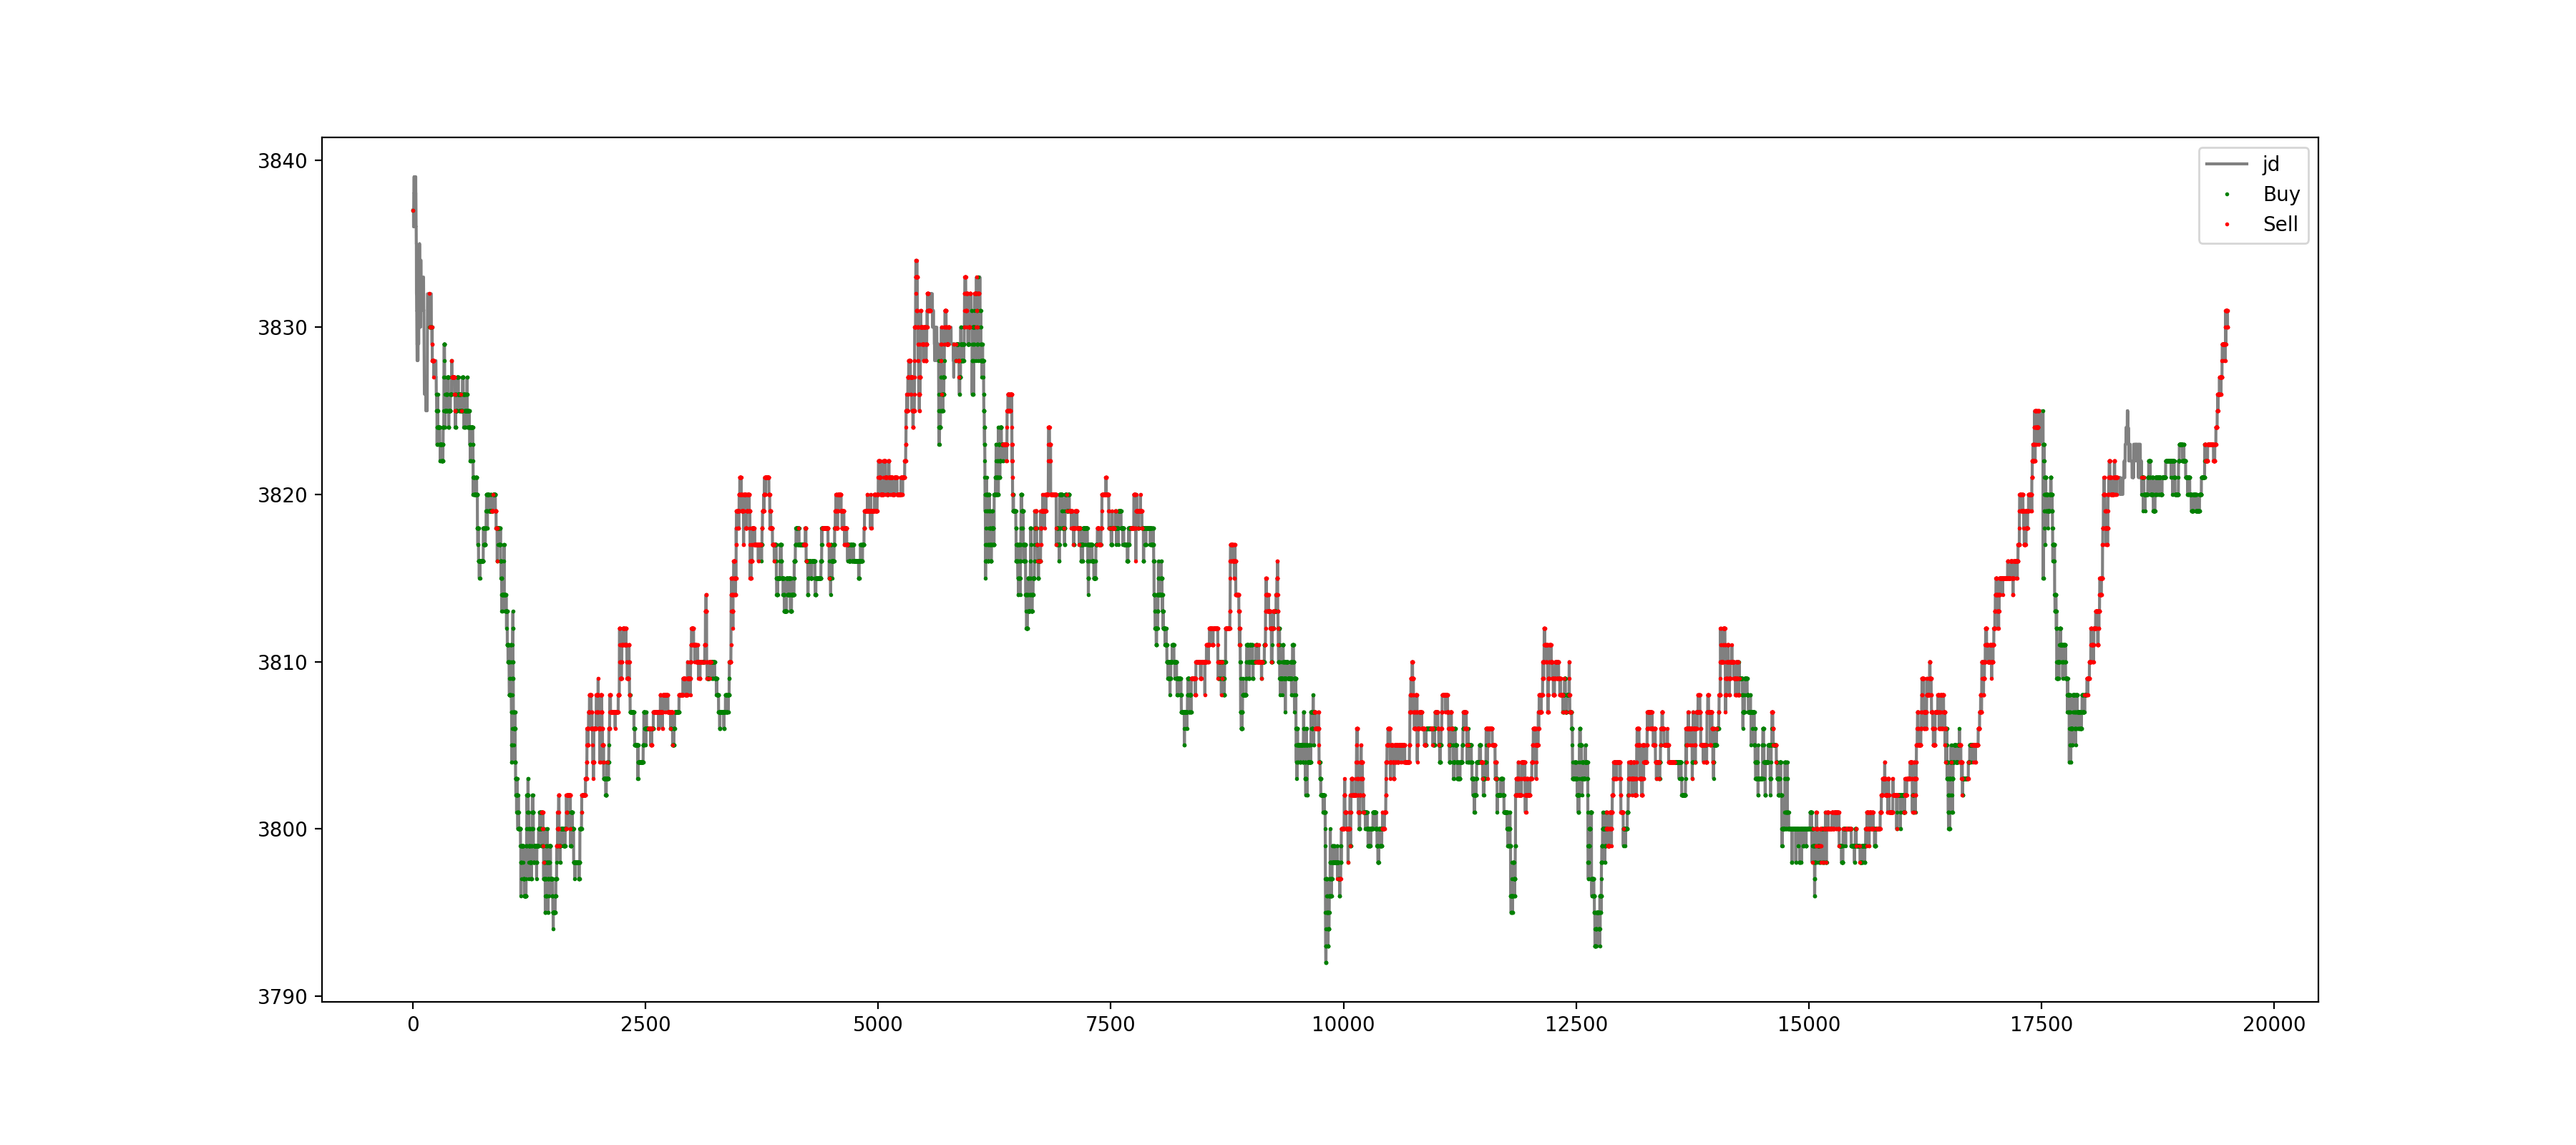

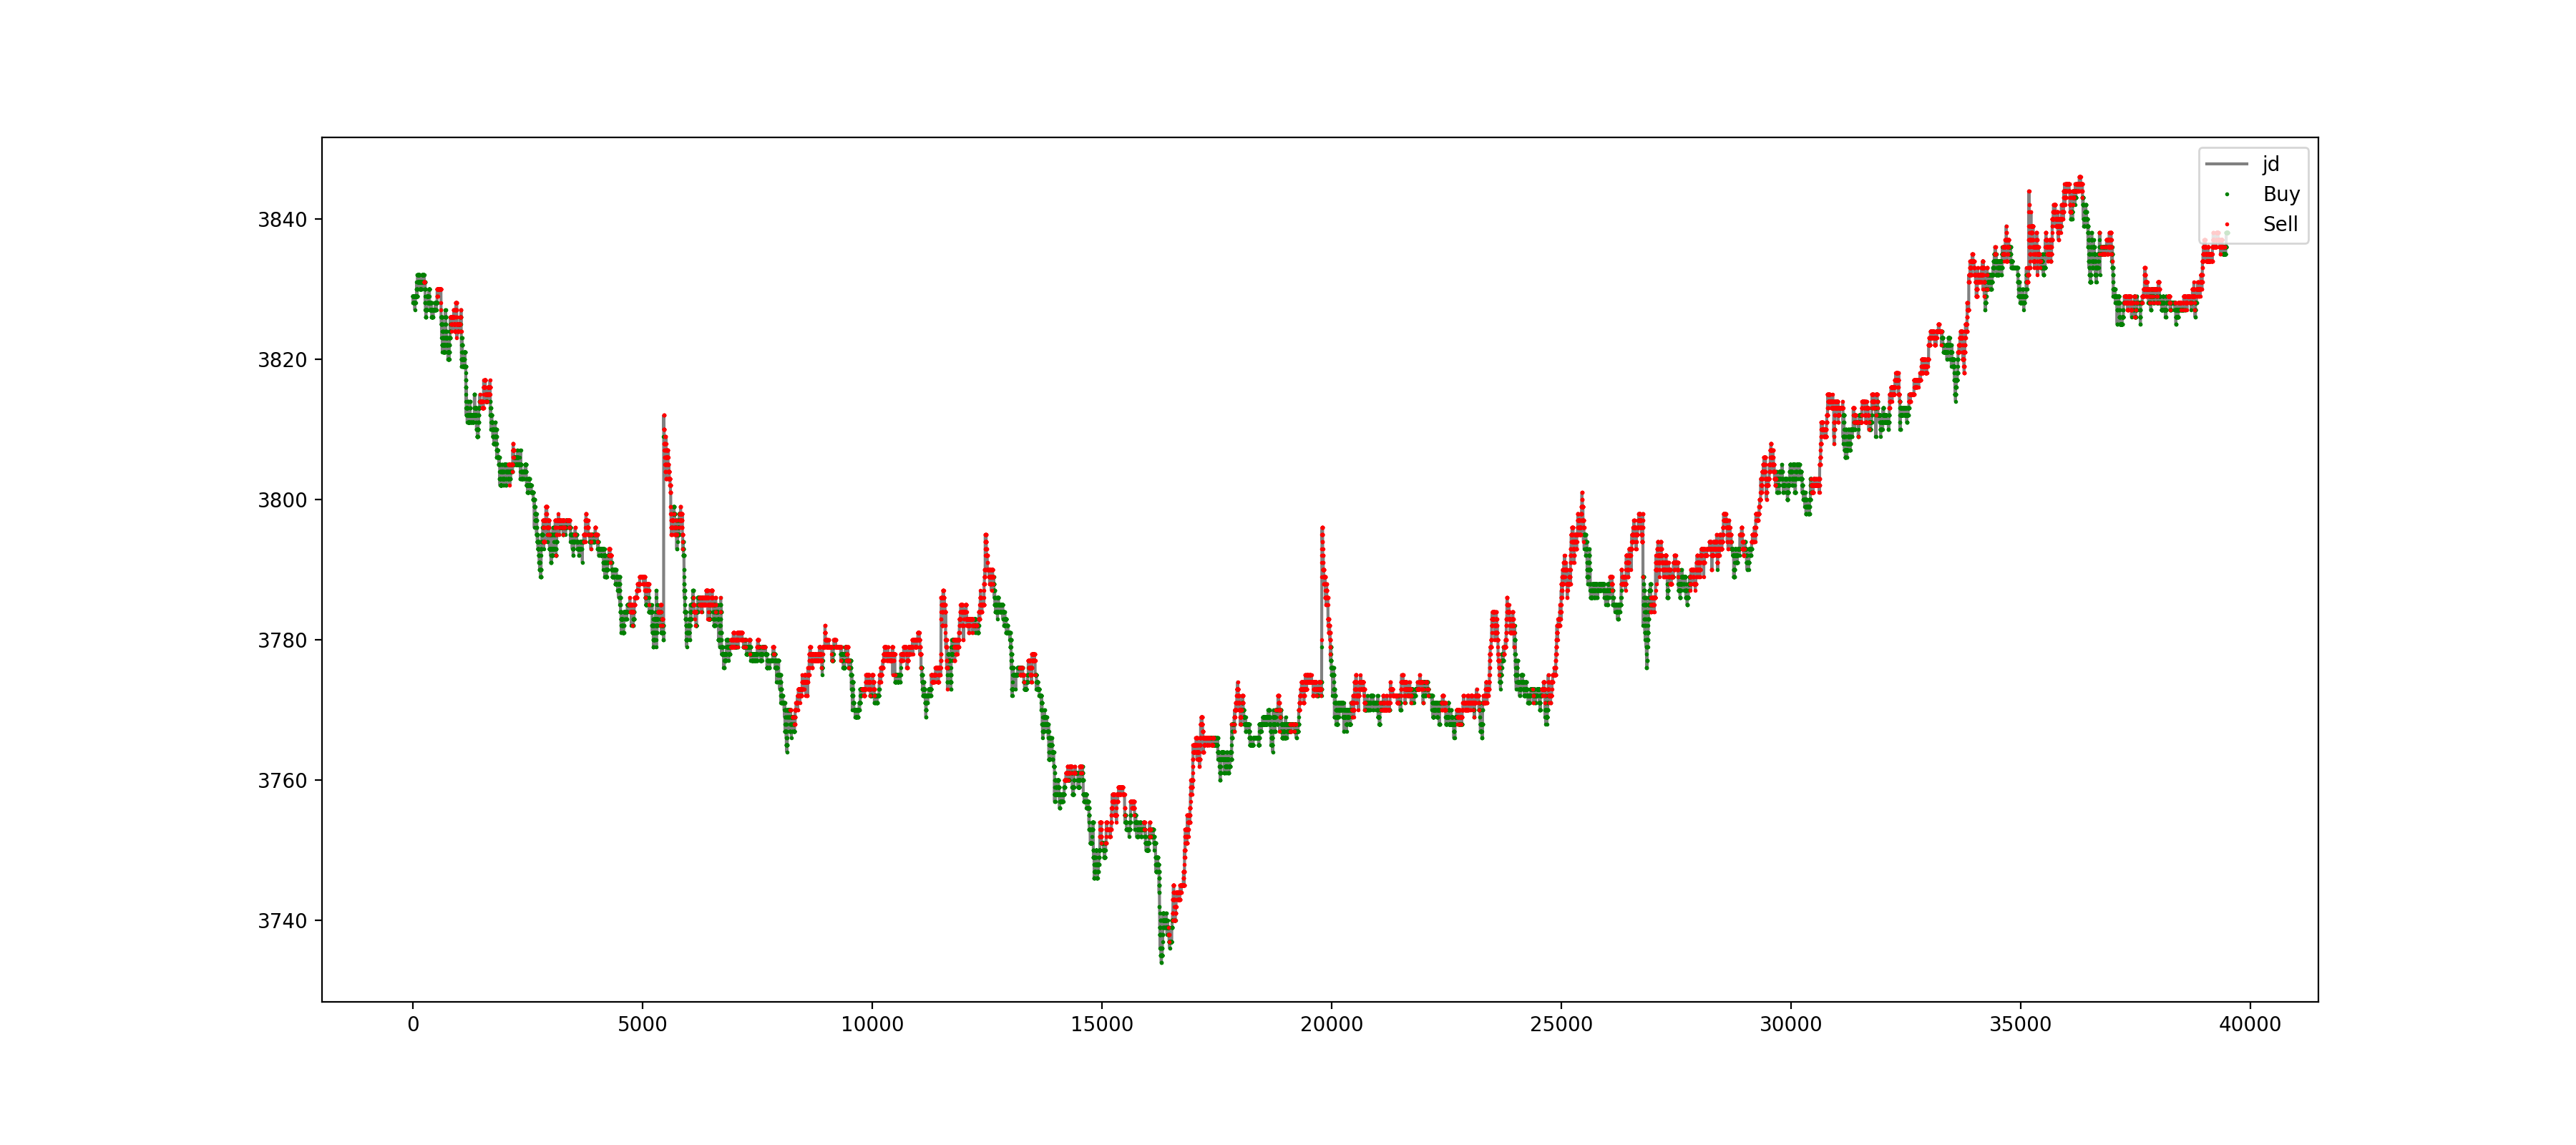

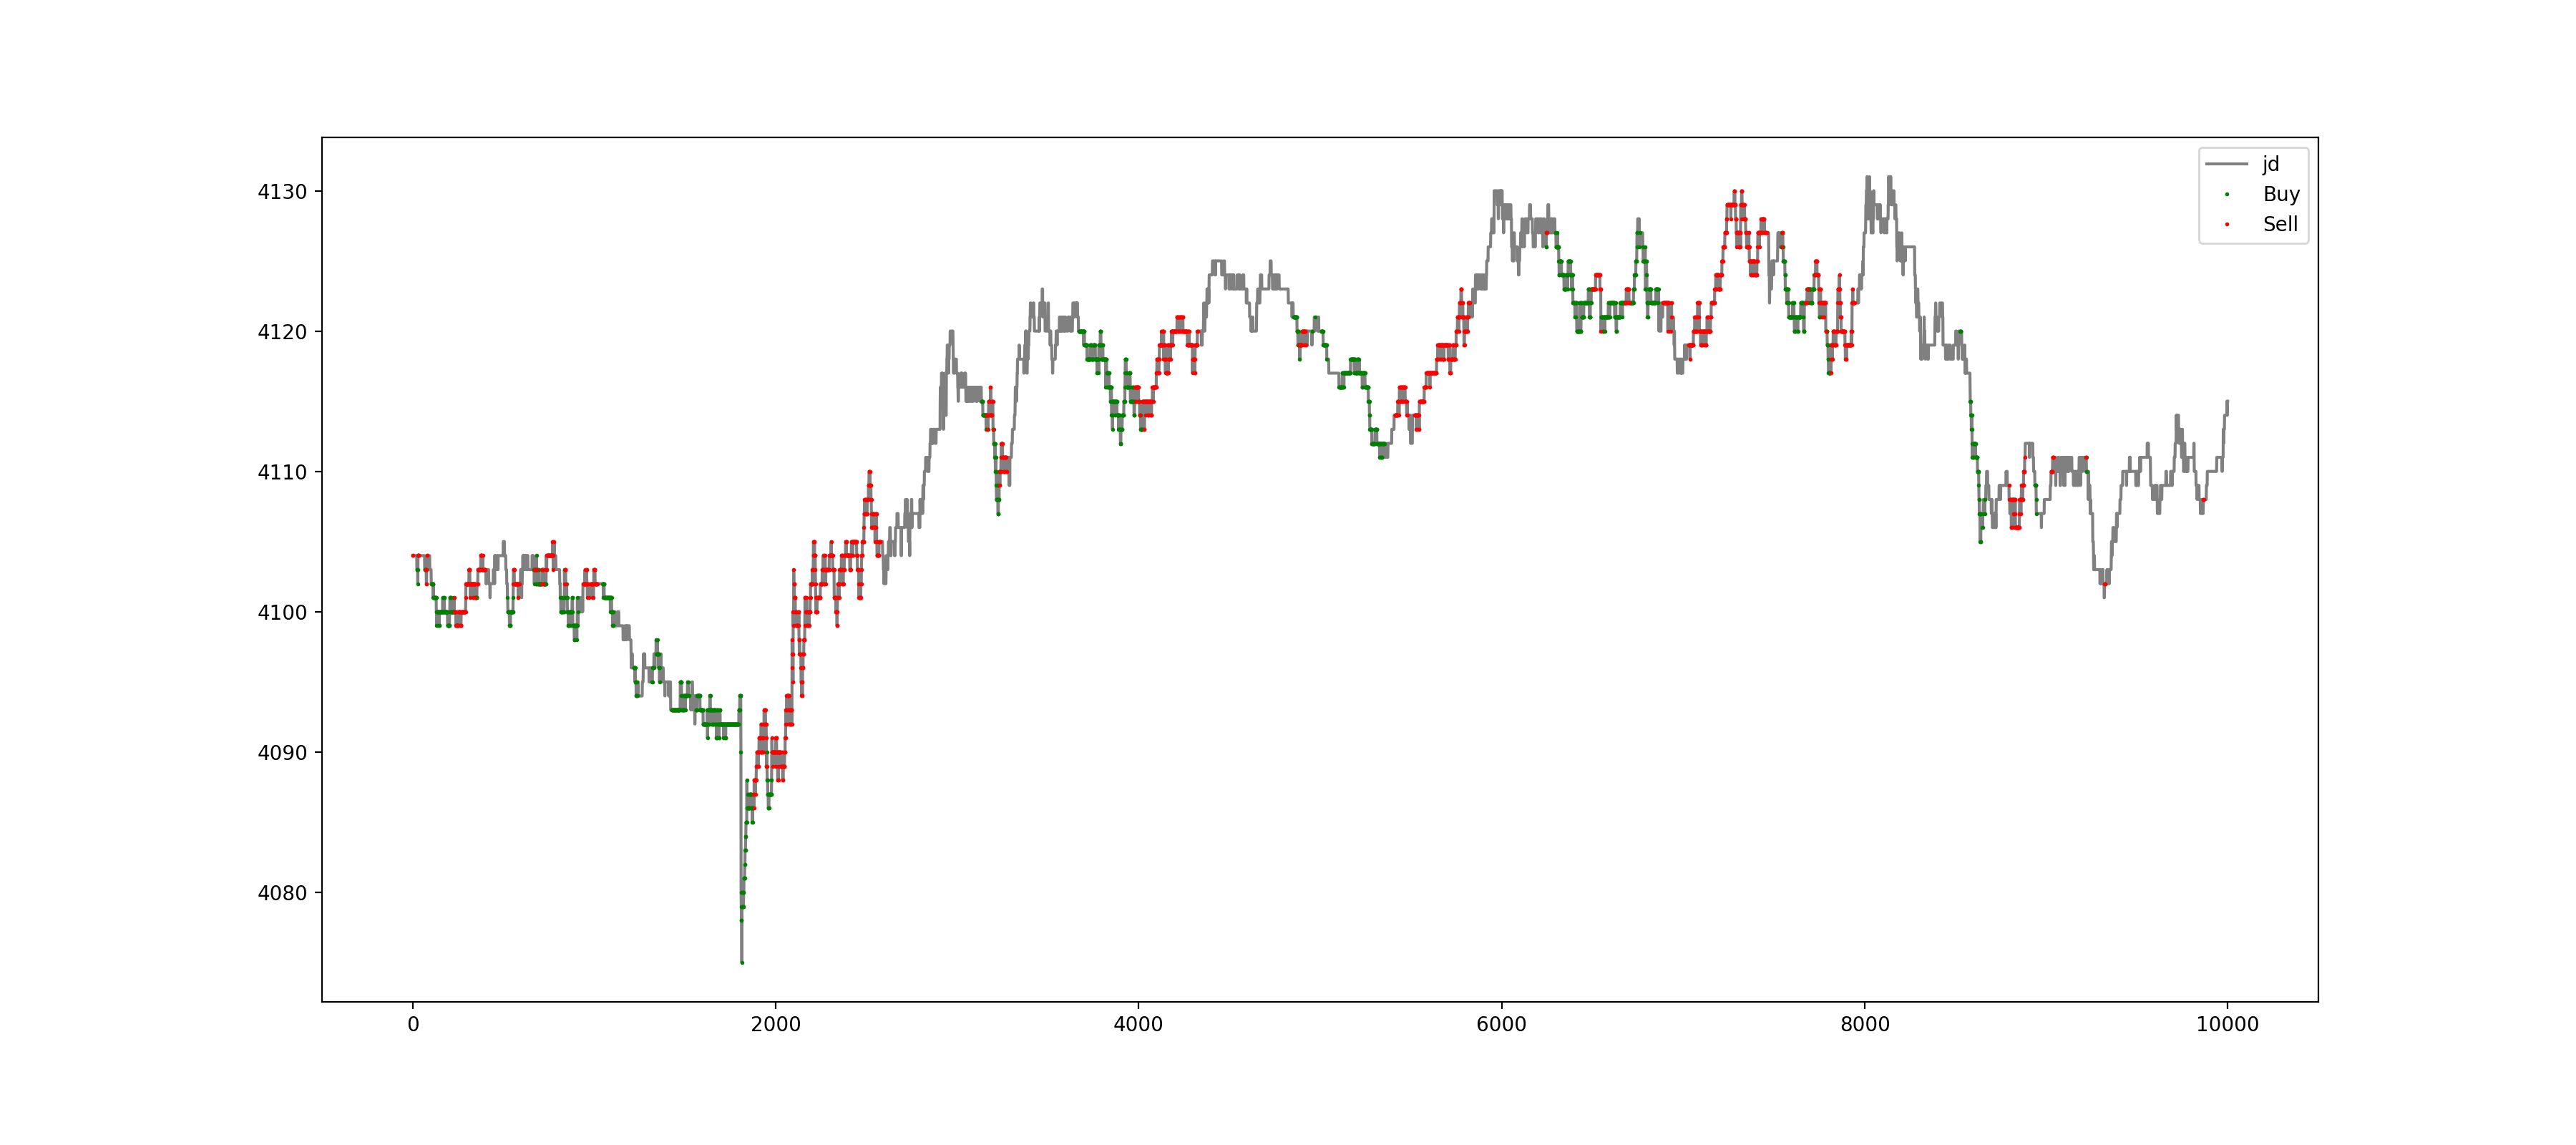

#### -----------------------------------------------------------------------------